<a href="https://colab.research.google.com/github/fariszahid002/CSC3632_Practical1/blob/main/Copy_of_Part2_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Analytics, Computer Vision & AI - CSC3831
## Coursework, Part 2: Machine Learning

As this coursework is as much about practical skills as it is about reflecting on the procedures and the results, you are expected to explain what you did, your reasoning for process decisions, as well as a thorough analysis of your results.

### 1. Load the MNIST dataset, visualise the first 20 digits, and print their corresponding labels.

In [ ]:
# Run this to load the MNIST dataset
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    'mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False
)

## Visualising the First 20 Digits of the MNIST Dataset

It is always beneficial to plot the dataset you are working with as it provides insight into the type and quality of data. In this case, visualising the first 20 digits allowed me to confirm that the dataset is loaded correctly and that each image matches its label. The grayscale images accurately represent handwritten digits from 0 to 9, with clear and correct labeling.

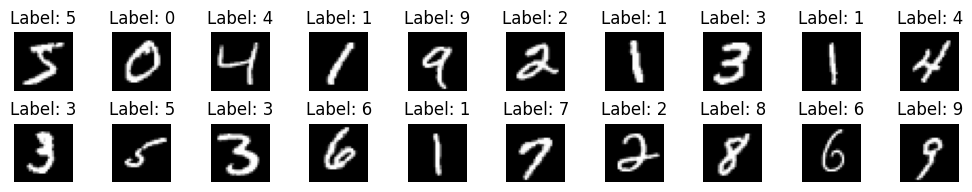

In [ ]:
import matplotlib.pyplot as plt

# Visualise the first 20 digits
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
axes = axes.ravel()

for i in range(20):
    image = X[i].reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {y[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Looking at these 20 digits, I notice a variety of handwriting styles and slight differences in how each digit is written. This variety shows that the dataset is diverse and that recognising digits accurately might be challenging. To understand how these differences might affect accuracy, I will continue with a deeper analysis in the next steps.

### 2. Train a Logistic Regression classifier on this data, and report on your findings.
    
1. Tune your hyperparameters to ensure *sparse* weight vectors and high accuracy.
2. Visualise the classification vector for each class.

## Training a Logistic Regression Classifier

In this part of the analysis, I trained a Logistic Regression classifier on the MNIST dataset with the aim of achieving high classification accuracy while ensuring sparsity in the model's weight vectors.

To begin, I split the dataset into training and test sets, using 80% for training and 20% for testing. This setup provides a large enough sample for the model to learn patterns effectively, while reserving an unbiased portion for performance evaluation. Next, I established a baseline Logistic Regression model to serve as an initial benchmark.

For this baseline, I set the tolerance parameter (`tol=0.1`) to speed up convergence, as the default tolerance (0.0001) is very low and would take a long time to execute. I also set `max_iter=1000` to allow sufficient iterations for the model to reach convergence, as the default of 100 iterations often triggers a `ConvergenceWarning` on large datasets like MNIST, indicating it might not fully converge within that limit.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(tol=0.1, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 91.71%


The baseline model achieved an accuracy of 91.71% on the test set, which is strong for a simple Logistic Regression model on the MNIST data. This high initial accuracy provides a solid starting point, and we can now focus on further tuning to potentially improve accuracy, sparsity, and model efficiency for a more interpretable result.

## Hyperparameter Tuning for Logistic Regression

To achieve both **sparse weight vectors** and **high accuracy** in our logistic regression model, I applied `GridSearchCV` for hyperparameter tuning. The parameters I aimed to optimize were the regularization strength, denoted by C, and the solver choice. I restricted the penalty to `l1` for this tuning because `l1` regularization is effective at driving some weights to zero, thus promoting sparsity by focusing the model on the most impactful features. Unlike `l2` regularization, which only shrinks weights without zeroing them, `l1` regularization is better suited for our goal of achieving sparse weight vectors.

I tested two solvers, `saga` and `liblinear`, both of which support `l1` regularization. This ensures compatibility and allows flexibility in execution time and convergence behavior, as each solver might handle the optimization process differently.

For the C parameter, I defined a range of values [0.001, 0.001, 0.1, 1, 10], covering a spectrum from strong regularization (low C values) to minimal regularization (high C values). A lower C value implies stronger regularization, which encourages sparsity by zeroing out less significant weights. Using `cv=3` for cross-validation provided a good balance between speed and reliable model evaluation, allowing each model to be tested on different parts of the data for consistent performance measurement.

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(tol=0.1, max_iter=1000, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['saga', 'liblinear'],
    'penalty': ['l1']
}

# Tuning hyperparameters
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_best)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated Score: {grid_search.best_score_:.2%}")
print(f"Accuracy: {tuned_accuracy:.2%}")

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
Cross-validated Best Accuracy: 91.95%
Test Accuracy with Tuned Model: 91.99%


After running `GridSearchCV`, the best parameters were identified as `C=1`, `solver=saga`, and `penalty=l1`. These parameters make sense for this model and dataset. A `C` value of 1 provides moderate regularization, balancing accuracy and promoting sparsity by encouraging some weights zero out. The `saga` solver is efficient for larger datasets like MNIST and supports `l1` regularization, which aligns with our goal of achieving sparse weight vectors.

The cross-validated best accuracy during tuning was 91.95%, and the test accuracy with the tuned model was 91.99%, showing an improvement over the baseline accuracy of 91.71%. This slight boost in accuracy, combined with the increased sparsity from `l1` regularization, indicates that the tuning process effectively enhanced the model's performance and interpretability without overfitting. Overall, the tuned model achieves a good balance between accuracy and sparsity, meeting the objectives set for this experiment.

## Visualise the Classification Vector for Each Class

To visualise the classification vectors, we can look at the coefficients of the trained logistic regression model for each digit class (0 through 9). Each coefficient vector shows the importance of each pixel feature in predicting that specific digit, which can be visualised as an image to understand which pixels are emphasized in classifying a particular digit. This approach also helps in understanding how the model differentiates between classes based on pixel intensity patterns.

In my implementation, I used the `best_model.coef_` attribute from the tuned logistic regression model, which holds the coefficient vectors for each digit class. Each vector was reshaped into a 28x28 grid to match the MNIST image structure, enabling us to interpret the coefficients in the context of of each pixel's spatial position. I then plotted heatmaps of these coefficient vectors to visually highlight which pixels were most emphasized for each class. The `seismic` colormap was used because it clearly shows positive and negative values where red areas indicate pixels that strongly support the class prediction, while blue areas indicate pixels that strongly oppose it.

NameError: name 'best_model' is not defined

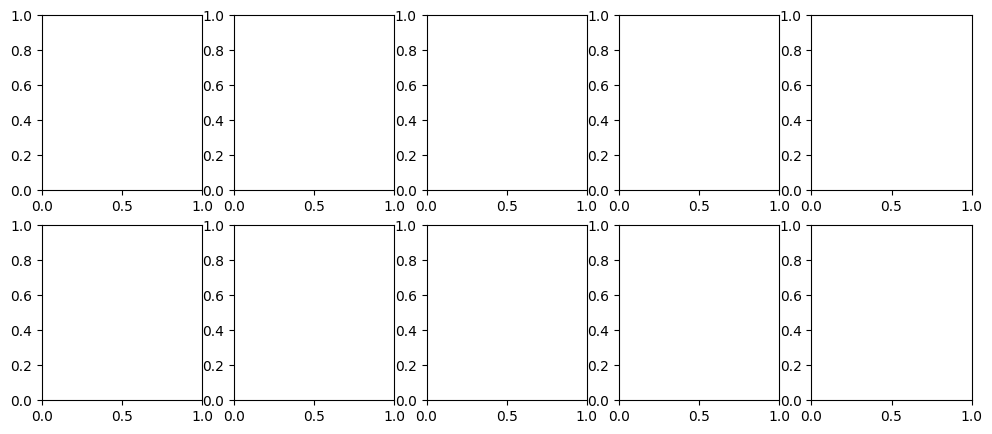

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    coef_image = best_model.coef_[i].reshape(28, 28)

    # Plotting heatmap
    axes[i].imshow(coef_image, cmap='seismic', aspect='auto')
    axes[i].set_title(f"Class {i}")
    axes[i].axis('off')

plt.suptitle("Classification Vectors (Coefficient Heatmaps) for Each Digit Class")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The heatmaps illustrate where the logistic regression model focuses when identifying each digit, with certain regions highlighted based on the structure of each digit. For example, red areas in the center for digits like "0" and "8" reflect their circular shapes, while "6" and "9" show emphasis in their inner holes. For "1," the strong weights along the center column capture its vertical shape. Digits "4" and "7" show unique patterns where "4" has emphasis along the top and left edges, capturing its horizontal and vertical lines, while "7" highlights the top row and right side, representing its characteristic shape. For "2" and "3," the weights align with their curved structures, with "2" showing more emphasis along the top and right curves and "3" along the right side for its double-curve shape. The "5" heatmap is mainly blue, indicating the model's reliance on the absence of features in specific areas to capture the digit's unique combination of curves and horizontal line.

Using L1 regularization, which promotes sparsity, results in lighter colors in some areas of the heatmaps, indicating that these pixels are less important or even ignored by the model for each digit. For example, we see less intense red edges in "2," "4," and "9," and lighter blue edges in "1," "3," "6," and "8." This reduction in color intensity suggests that the model focuses only on the most relevant parts of each digit, enhancing interpretability and potentially reducing overfitting by concentrating on essential features.

Overall, these heatmaps confirm that the logistic regression model captures distinct patterns for each digit, focusing on meaningful features for accurate digit recognition.


### 3. Use PCA to reduce the dimensionality of your training data.
    
1. Determine the number of components necessary to explain 80\% of the variance
2. Plot the explained variance by number of components.
3. Visualise the 20 principal components' loadings
4. Plot the two principal components for your data using a scatterplot, colouring by class. What can you say about this plot?
5. Visualise the first 20 digits, *generated from their lower-dimensional representation*.

## Dimensionality Reduction Using PCA

To reduce the dimensionality of the MNIST dataset, I applied Principle Component Analysis (PCA). I used scaling before applying PCA because PCA is sensitive to feature variance. Without scaling, features with larger variances, such as pixels with higher values, would dominate the principal components. By standardizing the data to have zero mean and unit variance, each feature contributes equally to the PCA transformation, allowing for a balanced analysis.

In this implementation, I first scaled the dataset using `StandardScaler` and then performed PCA without initially specifying the number of components. This allowed me to calculate the cumulative explained variance ratio for all components, which in turn helped me identify the minimum number of components needed to explain a specified level of variance. Here, I aimed to retain 80% of the variance in the dataset, which is generally a good balance between dimensionality reduction and retaining important information.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

# Scaling training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Applying PCA on scaled training data
pca = PCA()
pca.fit(X_train_scaled)

# cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Number of components to explain 80% of the variance: {n_components_80}")


Number of components to explain 80% of the variance: 148


The result showed that 148 components were needed to explain 80% of the variance after scaling. This means that these 148 components effectively capture most of the data's structure and information, reducing the dimensionality of the dataset from 784 to 148 while preserving the majority of its variance. It is worth mentioning that without scaling, only 43 components were needed to explain the same level of variance. This difference occurs because, without scaling, the features with larger variances dominate, allowing PCA to retain most of the variance in fewer components. However, this may lead to biased principal components and reduced interpretability.

## Plotting the Explained Variance by Number of Components

To understand how much of the variance of the dataset each principle component captures, I created a plot of the cumulative explained variance as the number of components increases.

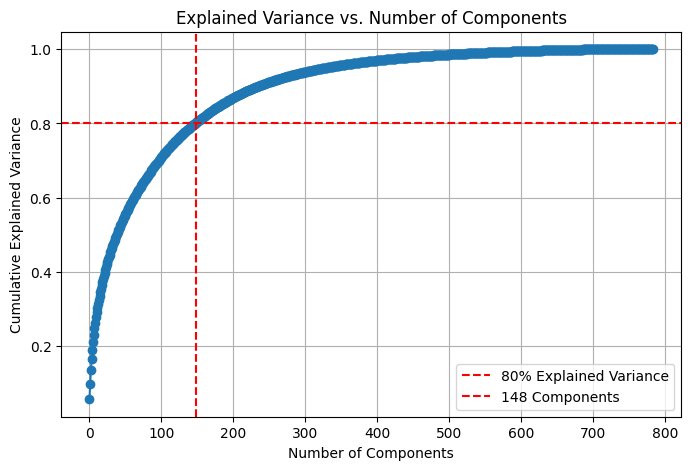

In [ ]:
# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.8, color='r', linestyle='--', label="80% Explained Variance")
plt.axvline(x=n_components_80, color='r', linestyle='--', label=f'{n_components_80} Components')
plt.legend()
plt.grid()
plt.show()

In this process, I calculated the cumulative variance by each component and plotted it against the number of components. The red dashed horizontal line marks the 80% cumulative explained variance threshold, and the red vertical line indicates the number of components required to reach this threshold, which in this case it is 148. This means that 148 principal components capture 80% of the data's variance, which suggests a good balance between dimensionality reduction and information retention.

The plot reveals that the cumulative explained variance rises quickly in the beginning but then levels off as more components are added. This means that after a certain number of components, each additional component contributes less new information. By selecting 148 components, I aim to keep most of the meaningful information in the data while reducing the feature space.

## Visualise the Principal Components' Loadings

Based on the findings about the number of principal components needed to explain 80% of the variance in the MNIST dataset and the cumulative variance plot, it is clear that not all components contribute equally to the structure of the dataset. By visualising only the first 20 principal components, I focus on those that capture the most important features and patterns in the data. These initial components hold the highest variance and are likely to reveal key structural patterns in the MNIST digits. Showing all 148 components would be unnecessary, as the later components add very little new information.

In this implementation, I reshaped each component from a 1D vector into a 28x28 grid to match the format of the original MNIST images. This way, each component can be visualised as an "image", making it easier to see important patterns. I used a grayscale color map (`cmap='gray'`) to highlight areas with positive and negative contributions, where more intense regions show high variability or importance across different digits.

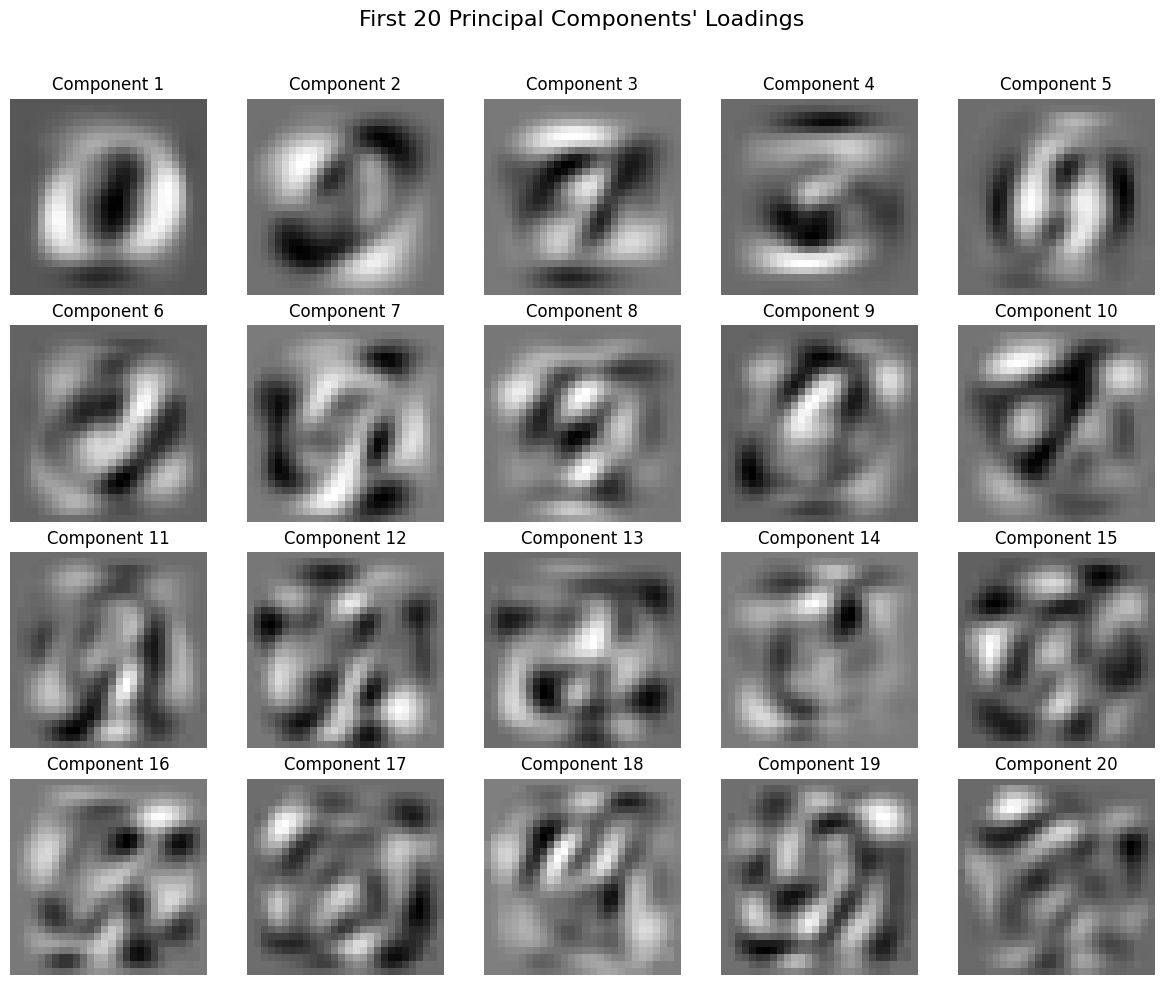

In [ ]:
# Plot the first 20 principal components' loadings
fig, axes = plt.subplots(4, 5, figsize=(12, 10))
fig.suptitle("First 20 Principal Components' Loadings", fontsize=16)

for i in range(20):
    ax = axes[i // 5, i % 5]
    ax.imshow(pca.components_[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Component {i+1}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Looking at the results, we can see that each principal component captures a mix of different digit patterns. Some components display dark, circular shapes in the center, which likely represent features common in digits like "0" and "8". Others show strong horizontal or vertical lines, hinting at characteristics of digits like "1" and "7". This diversity in patterns confirms that PCA is capturing important aspects of digit structure.

## Scatterplot of the Two Principal Components

Previously, when visualising the loadings of the first 20 principal components, we gained insight into the features that capture the most important variance across different digits.  This highlighted the structural patterns in the MNIST dataset. We further explore this by plotting the first two principal components as a scatterplot, coloured by class. This plot represents how the dataset is distributed when reduced to two dimensions, allowing us to examine class seperation.

In this implementation, I first applied PCA to the training data to reduce it to the first two principal components. Then, I created a DataFrame with these two components and the class labels to make plotting easier. Finally, I used `sns.scatterplot` in Seaborn to visualise the data in two dimensions, with colors representing the different digit classes.

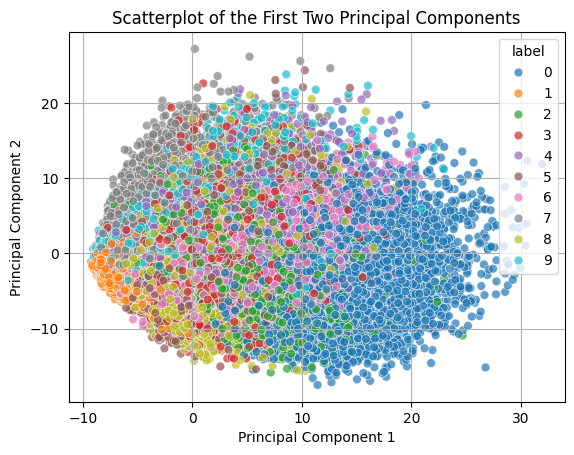

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Applying PCA to training data to reduce to first two principal components
X_train_pca = pca.transform(X_train_scaled)
df_pca = pd.DataFrame(X_train_pca[:, :2], columns=['PC1', 'PC2'])
df_pca['Class'] = y_train.astype(int)

# Plotting scatterplot of the two principal components
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Class', palette='tab10', legend='full', s=40, alpha=0.7)
plt.title('Scatterplot of the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='label')
plt.grid(True)
plt.show()

In the scatterplot, each point corresponds to an individual data sample, and colors represent different digit classes. We can see that some clusters overlap, suggesting similarities in feature across certain digits. For example, we can see digits like "0" and "6" might overlap due to their similar circular shapes. However, each class also has a distinct distribution pattern, indicating that the first two components capture key structural differences in the dataset. This supports our earlier finding that the initial principal components retain important information, allowing us to distinguish between digit classes even with reduced dimensions.

## Visualise Digits Generated from Their Lower-Dimensional Representation

For this part, I visualise the first 20 reconstructed digits from their reduced-dimensional representation. In this implementation, I use the selected 148 components (which explains 80% of the variance) to project the data into a lower-dimensional space and then reconstruct it back to the original dimension. This allows us to see how well the reduced representation preserves the original digit information.

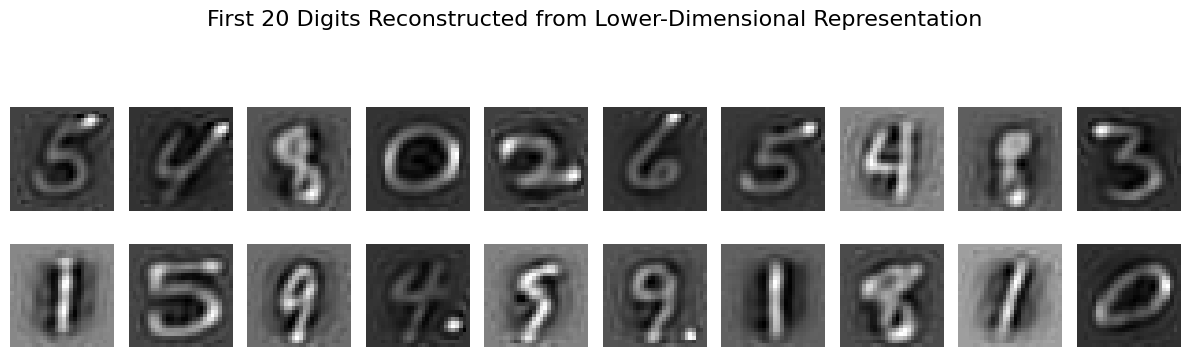

In [ ]:
# Reducing dimensionality to 148 number of components
pca_final = PCA(n_components=n_components_80)
X_train_pca = pca_final.fit_transform(X_train_scaled)

# Inverse transform to reconstruct the images
X_train_reconstructed = pca_final.inverse_transform(X_train_pca)

# Visualise the first 20 reconstructed digits
fig, axes = plt.subplots(2, 10, figsize=(12, 4))
fig.suptitle("First 20 Digits Reconstructed from Lower-Dimensional Representation", fontsize=16)

for i in range(20):
    ax = axes[i // 10, i % 10]
    ax.imshow(X_train_reconstructed[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In the reconstructed images, we can see that although some fine details are lost, the overall shapes and distinguishing features of each digit remain clear. This confirms that PCA effectively compresses the data while preserving important patterns. This visualisation demonstrates that PCA can be a useful tool for dimensionality reduction, retaining enough information for tasks like classification or image reconstruction.

### 4. Generate a noisy copy of your data by adding random normal noise to the digits **with a scale that doesn't completely destroy the signal**. This is, the resulting images noise should be apparent, but the numbers should still be understandable.
    
1. Visualise the first 20 digits from the noisy dataset.
2. Filter the noise by fitting a PCA explaining **a sufficient proportion** of the variance, and then transforming the noisy dataset. Figuring out this proportion is part of the challenge.
3. Visualise the first 20 digits of the de-noised dataset.

## Adding Noise to the Dataset

I generated a noisy version of the MNIST dataset by adding random normal noise to each digit image. The goal of adding noise in this context is to simulate real-world imperfections, like image artifacts or slight distortions, which are common in practical settings. This controlled noise allows us to test our machine learning model, ensuring they can accurately classify digits even when images are not that clear. It is worth noting that I added noise at a scale that does not completely obscure the digit (`noise_level=0.5`), ensuring that the essential structure of each digit still remains intact. This balance is crucial for preserving meaningful information while still introducing variability.

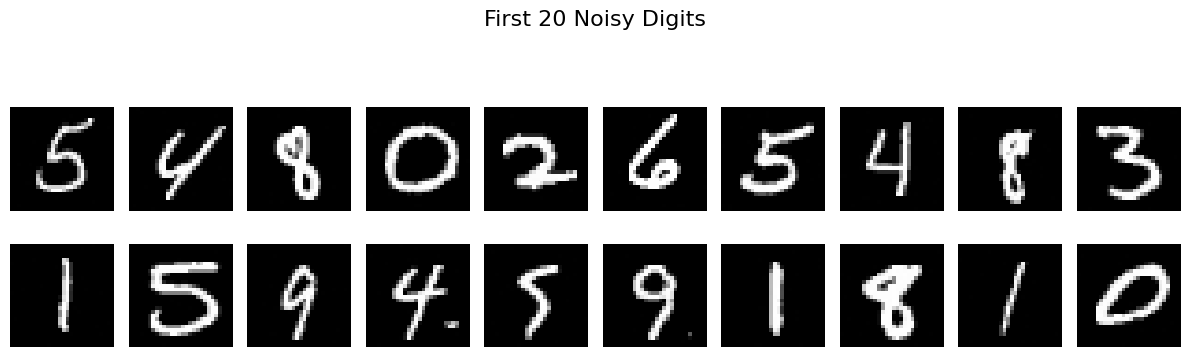

In [ ]:
import matplotlib.pyplot as plt

# Generate noisy data
noise_level = 0.5
X_train_noisy = X_train + noise_level * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

# Clip the pixel values to be between 0 and 255.
X_train_noisy = np.clip(X_train_noisy, 0, 255)

# Visualise the first 20 noisy digits
fig, axes = plt.subplots(2, 10, figsize=(12, 4))
fig.suptitle("First 20 Noisy Digits", fontsize=16)

for i in range(20):
    ax = axes[i // 10, i % 10]
    ax.imshow(X_train_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Looking at the visualisation of the first 20 noisy digits, the added noise is apparent (digits looking blurry) but non-disruptive. Each digit can still be recognisable despite the added distortions. This confirms that the noise level effectively simulates real-world imperfections without obscuring the digits.

## Filtering Noise Using PCA and Visualising Denoised Digits

To filter the noise I previously added to the MNIST dataset, I applied PCA to explain a sufficient proportion of the variance, followed by transforming the noisy dataset. The challenge here is to determine the sufficient proportion of variance to retain, as too few components may overly simplify the data and lose important digit details, while too many components may retain too much noise.

Similar to my previous implementation, I first scaled the noisy data before applying PCA. I initially chose to retain 95% of the variance, as this threshold is commonly used in the MNIST dataset and offers a balance between dimensionality reduction and information preservation. Using the selected number of components, I transformed the noisy data and then reconstructed it back to its original to visualise the denoised digits.

Number of components to retain 95% of the variance: 397


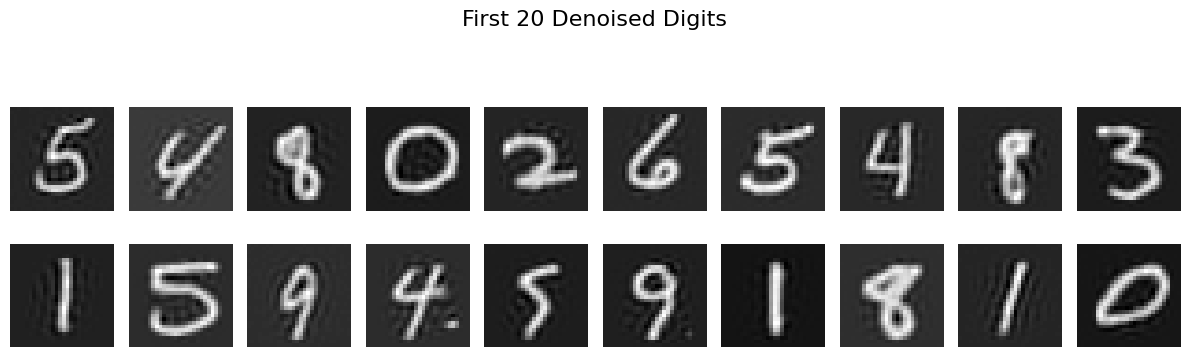

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Scale data
scaler = StandardScaler()
X_train_noisy_scaled = scaler.fit_transform(X_train_noisy)

# Applying PCA
pca = PCA()
pca.fit(X_train_noisy_scaled)

# Cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
sufficient_variance = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% of the variance: {sufficient_variance}")

# Transforming the scaled noisy data
pca_filtered = PCA(n_components=sufficient_variance)
X_train_noisy_reduced = pca_filtered.fit_transform(X_train_noisy_scaled)
X_train_denoised = pca_filtered.inverse_transform(X_train_noisy_reduced)

# Reconstructing to its original
X_train_denoised = scaler.inverse_transform(X_train_denoised)

# Visualise the first 20 denoised digits
fig, axes = plt.subplots(2, 10, figsize=(12, 4))
fig.suptitle("First 20 Denoised Digits", fontsize=16)
for i in range(20):
    ax = axes[i // 10, i % 10]
    ax.imshow(X_train_denoised[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Looking at the first 20 denoised digits, the images retain the features of each digit, though some fine details appear slightly blurry. Interestingly, the denoised digits are somewhat blurrier than the noisy versions. This blurriness is likely a result of the PCA-based dimensionality reduction process. By retaining 95% of the variance, I used 397 components, which preserves most of the important information but leads to a slight loss in fine detail. I also experimented with retaining a higher variance (approaching the 100% mark), which increased the number of components and reduced the blurriness. However, retaining more components also risks keeping some of the original noise. The trade-off here is between preserving important structural features and effectively filtering out noise while accepting some loss of finer details.